In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy.special import expit
from scipy.optimize import minimize_scalar

import copy

from numpy.linalg import pinv
from sklearn.datasets import load_iris
from scipy.optimize import fmin_bfgs

import multiprocessing as mp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [3]:
class Linear:
    def val(x):
        return x
    def dev(x):
        return 1
class TANH:
    def val(x):
        return np.tanh(x)
    def dev(x):
        return 1 - np.tanh(x)*np.tanh(x)
class Sigmoid:
    def val(x):
        return 1 / (1 + np.exp(-x))
    def dev(x):
        return (1 / (1 + np.exp(-x))) * (1-1 / (1 + np.exp(-x)))
class Relu:
    def val(x):
        return np.maximum(x.copy(),0)
    def dev(x):
        return (x>0).astype(int)
class ArcTan:
    def val(x):
        return np.arctan(x)
    def dev(x):
        return 1/(x*x+1)
class SiLU:
    def val(x):
        return x / (1 + np.exp(-x))
    def dev(x):
        return x / (1 + np.exp(-x)) + (1-x / (1 + np.exp(-x))) / (1 + np.exp(-x))


def no_decay(eta,t,epoch):
    return eta
def exp_decay(eta,t,epoch):
    k = 0.001
    lrate = eta * np.exp(-k*t)
    return lrate
def inverse_decay(eta,t,epoch):
    lrate = eta /(1+t/epoch)
    return lrate

So, we can write the cost function in the following fashion.
\begin{equation*}
cost\_ function = f_i(\phi_{i} (M_i \phi_{i-1}(M_{i-1} N_{i-2}+b_{i-1}) + b_i))
\end{equation*}
in which, $f_i$ represents all the afterward layers and the cost function definition, $b_i$ is the bias term for the $i$-th layer, and $N_i$ is the neuron value of the $i$-th layer, $V_i$ is the value before apply the activation function($V_i = M_{i} N_{i-1}+b_{i}$). 

We find that:
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* N_{i-1}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})
\end{equation*}
In principle we can also write the third equation as,
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_{i-1} ^{'}(N_{i-1})*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
which gives us that
\begin{equation*}
 f_{i-1} ^{'}(N_{i-1})= f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}
\end{equation*}
We can refer $f_i ^{'}(N_{i})$ as the derivative_prefix, and as long as we can keep track of the derivative_prefix in different layers, we can calculate the partial derivative of each layer efficiently.

Note that, in the formulas above, we only show the ingredients of every equation for the purpose of simplicity, in the actual formula, we need to move the matrice around and use different multiplications carefully.

The actual iterations are as follow:
\begin{equation*} 
 f_{i-1} ^{'}(N_{i-1})=  M_{i}^T@f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)@ N_{i-1}^T
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i) @ I
\end{equation*}
In the last formula, $I$ is a matrix with value 1.


We start with the last layer, and the initial derivative_prefix is the derivative of the cost_fuction (either mean square error or cross entropy).

In [4]:
class Sequential(object):
    def __init__(self, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate = no_decay,
                 early_stopping=False):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.metric = metric
        self.verbose = verbose
        self.regular = regular
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        
        self.dims = []
        self.acts = []
        
        self.matrice = []
        self.bias = []
        self.vects = [] #before the activation function
        self.neurons = [] #after the activation function
        self.dropout = [] #to be implemented later
        self.Y = []
        
        self.loss = []
        
    def add(self,arg,argv):
        '''
        add('Dense',12)
        add('Dense',15)
        add('Activation',Sigmoid)
        add('Activation',Relu)
        add('Dropout',0.5)
        '''
        if arg == 'Dense':
            if len(self.dropout) < len(self.dims):
                self.dropout.append(0)
            if len(self.dims) == 0:
                self.dims.append([0,argv])
            else:
                self.dims.append([self.dims[-1][-1],argv])
        if arg == 'Activation':
            self.acts.append(argv)
        if arg == 'Dropout':
            self.dropout.append(argv)
        return
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_params(self,X,Y):
        for row,col in self.dims:
            W_num_elems = row*col
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(col, row) # reshape to be W
            self.matrice.append(W)
            
            b = np.random.uniform(-1.0, 1.0, size=col)
            b = b.reshape(col, 1)
            self.bias.append(b) #adding bias vector
        
        self.neurons.append(X.T)
        self.Y = self._encode_labels(Y)
        return
    
    def activate(self,vec,act):
        return act.val(vec)
    
    def activate_dev(self,vec,act):
        return act.dev(vec)
    
    def _feedforward(self):
        '''
        clear the previous feedforward result
        '''
        self.neurons = self.neurons[:1]
        self.vects = []
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            self.vects.append(W @ self.neurons[-1] + b)
            self.neurons.append(self.activate(self.vects[-1],act))
        m = self.Y.shape[1]
        if self.cost_function == 'quadratic':
            self.loss.append(((self.neurons[-1]-self.Y)*(self.neurons[-1]-self.Y)).sum()/m)
        elif self.cost_function == 'cross_entropy':
            cost = -(1.0/m) * np.sum(self.Y*np.log(self.neurons[-1]) + (1-self.Y)*np.log(1-self.neurons[-1]))
            self.loss.append(cost)
        return

    def predict(self,X_test):
        neuron = X_test.T
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            vec = W @ neuron + b
            neuron = self.activate(vec,act)
        y_pred = np.argmax(neuron, axis=0)
        return y_pred

    def set_init_dev_prefix(self):
        if self.cost_function == 'quadratic':
            return -2 * (self.Y - self.neurons[-1])
        if self.cost_function == 'cross_entropy':
            return -(self.Y-self.neurons[-1])

    def _update_params(self):
        cur_dev_prefix = self.set_init_dev_prefix()
        grads = []
        bias_grads = []
        for N,N1,V,act,W in zip(self.neurons[1:][::-1],self.neurons[:-1][::-1],self.vects[::-1],self.acts[::-1],self.matrice[::-1]):
            cur_dev_prefix *= self.activate_dev(V,act)
            grads.append(cur_dev_prefix @ N1.T)
            bias_grads.append(cur_dev_prefix @ np.full((cur_dev_prefix.shape[1], 1), 1))
            cur_dev_prefix = W.T @ cur_dev_prefix
        grads.reverse()
        bias_grads.reverse()
        
        if self.regular != 'None':
            for W,b,grad,bias_grad in zip(self.matrice,self.bias,grads,bias_grads):
                if 'L2' in self.regular:
                    grad += 2*self.C * W
                    bias_grad += 2*self.C * b
                if 'L1' in self.regular:
                    grad += ((W>0).astype(int)-0.5)*(2*self.C)
                    bias_grad += self.C *((b>0).astype(int)-0.5)*(2*self.C)
                    
        for W,grad,b,bias_grad in zip(self.matrice,grads,self.bias,bias_grads):
            W -= self.eta * grad
            b -= self.eta * bias_grad
        return
    
    def fit(self,X,Y):
        self.dims[0][0] = X.shape[1]
        if len(np.unique(Y)) != self.dims[-1][-1]:
            print('Error: output dimension is wrong!')
            return False
        self._initialize_params(X,Y)
        eta_0 = self.eta

        for i in range(self.epochs):
            self.eta = self.learning_rate(eta_0,i,self.epochs)
            self._feedforward()
            self._update_params()

            if self.verbose and not i % max(1,int(self.epochs/10)):
                if self.metric == 'accuracy':
                    accu = accuracy_score(np.argmax(self.neurons[-1], axis=0),Y)
                if self.metric == 'customized':
                    accu = cost_metric()
                print('{} percent finished, current accuracy is {:.3f}.'.format(100*i//self.epochs,accu))
        if self.verbose:
            plt.figure()
            plt.plot([i for i in range(self.epochs-1)],self.loss[1:])
            plt.xlabel('Epoch number')
            plt.ylabel('Loss')
        print('Training is done!')
        return

In [5]:
full_df = pd.read_csv('data/processed_data.csv')

Y = full_df['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
data_cols = list(full_df)
data_cols.remove('readmitted')
X = full_df[data_cols].values

model = Sequential(C=0.001, epochs=2000, eta=0.00001, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=no_decay)

model.add('Dense',20)
model.add('Activation',Relu)
model.add('Dense',3)
model.add('Activation',Sigmoid)



model.fit(X,Y)
print(model.predict(X))
print(Y)

0 percent finished, current accuracy is 0.132.


KeyboardInterrupt: 

In [6]:
from sklearn.model_selection import GridSearchCV

In [17]:
def estimator(param):
    model = Sequential(C=0, epochs=2000, eta=0.00001, random_state=42, 
                 cost_function=param['cost_function'], 
                 metric='accuracy',
                 verbose=0,
                 regular='None',
                 learning_rate=no_decay)
    for neu_nbr, act in zip(param['Layers'],param['Activations']):
        model.add('Dense',neu_nbr)
        model.add('Activation',act)
    model.fit(X,Y)
    y_pred = model.predict(X)
    acc = accuracy_score(y_pred,Y)
    return acc

In [23]:
import random
param_test = []
activation_list = [Linear,TANH,Sigmoid,Relu,ArcTan,SiLU]*5
for cost_function in ['cross_entropy','quadratic']:
    for layer_nbr in range(2,4,1):
        for k in range(4):
            #for same objective function and nbr of layers, create 4 sets of parameters
            neuron_list = [random.randint(5,40) for i in range(layer_nbr-1)] + [3]
            #neuron number of hidden layers vary from 5 to 40
            random.shuffle(activation_list)
            act_list = activation_list[:layer_nbr-1] + [Sigmoid]
            #activation function of hidden layers are randomly selected
            tmp_param = {'cost_function':cost_function,'Layers':neuron_list,'Activations':act_list}
            param_test.append(tmp_param)

In [19]:
for param in param_test:
    print(estimator(param))

Training is done!
0.7733333333333333
Training is done!
0.46
Training is done!
0.7466666666666667
Training is done!
0.14
Training is done!
0.6666666666666666
Training is done!
0.4666666666666667
Training is done!
0.7733333333333333


KeyboardInterrupt: 

In [22]:
import multiprocessing as mp
pool = mp.Pool(processes=2)
res = pool.map(estimator,param_test)
print(res)

Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
Training is done!
[0.7733333333333333, 0.46, 0.7466666666666667, 0.14, 0.6666666666666666, 0.4666666666666667, 0.7733333333333333, 0.8066666666666666, 0.4866666666666667, 0.8666666666666667, 0.18, 0.8, 0.7266666666666667, 0.94, 0.3333333333333333, 0.5066666666666667]


0 percent finished, current accuracy is 0.333.
10 percent finished, current accuracy is 0.780.
20 percent finished, current accuracy is 0.853.
30 percent finished, current accuracy is 0.927.
40 percent finished, current accuracy is 0.953.
50 percent finished, current accuracy is 0.973.
60 percent finished, current accuracy is 0.973.
70 percent finished, current accuracy is 0.973.
80 percent finished, current accuracy is 0.973.
90 percent finished, current accuracy is 0.973.
Training is done!


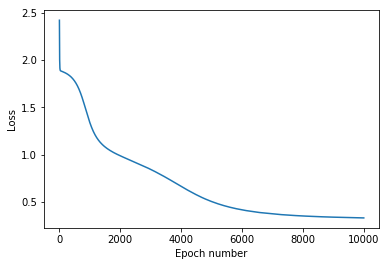

In [7]:
model = Sequential(C=0.1, epochs=10000, eta=0.001, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=inverse_decay)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)

ds = load_iris()
X = ds.data
X_test = StandardScaler().fit(X).transform(X)
X = StandardScaler().fit(X).transform(X)
Y = ds.target # note problem is NOT binary anymore, there are three classes!


model.fit(X,Y)
#print(model.predict(X))
#print(Y)

In [ ]:
from sklearn.datasets import load_digits

ds = load_digits()
X = ds.data/16.0-0.5
Y = ds.target

model = Sequential(C=0.1, epochs=1000, eta=0.001, random_state=None, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=no_decay)
model.add('Dense',60)
model.add('Activation',Sigmoid)
model.add('Dense',10)
model.add('Activation',Sigmoid)



model.fit(X,Y)

print(model.predict(X))